## 2. Correlation of SS and Admix with Usages

In [ ]:
import os 
import pandas as pd 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

from sklearn.metrics.pairwise import cosine_similarity
import sys
from tqdm import tqdm
sys.path.append('..')
from Wassgard.wassgard import io,annotate
import os 
import pandas as pd


def load_pdx_results(file_type):

    genome = "mm10" if "mm" in file_type else "GRCh38"

    silver_dir = "Z:/MorrissyLab Dropbox/Visium_profiling/results/cNMF"

    silver_standard_dict = {
        "spectra_mm": 'GBM_PDX_Visium_Mm_K90/cNMF_output/Mm_all.gene_spectra_score.k_90.dt_0_10.txt',
        "spectra_hs": 'GBM_PDX_Visium_Hs_K15/cNMF_output/Hs_all.gene_spectra_score.k_15.dt_0_10.txt',
        "usage_mm": 'GBM_PDX_Visium_Mm_K90/Consensus_matrix_modified/Mm_all.usages.k_90.dt_0_10.consensus_normalized_scaledwithadmix.txt',
        "usage_hs": 'GBM_PDX_Visium_Hs_K15/Consensus_modified/Hs_all.usages.k_15.dt_0_10.consensus_normalized_scaledwithadmix.txt'
    }

    annotation_df = pd.read_csv(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Tables\genome_biology_annotation.csv")
    annotation_df["program_name"] = annotation_df['cNMF_Program'] + "_" + annotation_df['Annotation_group1_short']

    if genome == 'GRCh38':
        ann_sub = annotation_df[annotation_df['Category'] == 'Tumor']
    else:
        ann_sub = annotation_df[annotation_df['Category'] != 'Tumor']

    rename_map = (
        ann_sub
        .set_index('SS_name')['program_name']
        .to_dict()
    )

    if file_type not in silver_standard_dict:
        raise ValueError(f"Invalid rank: {file_type}. Available ranks: {list(silver_standard_dict.keys())}")

    file_path = os.path.join(silver_dir, silver_standard_dict[file_type])
    
    cell2location_df = pd.read_csv(file_path, index_col=0, sep='\t')
    cell2location_df = cell2location_df.rename(columns=rename_map)

    return cell2location_df



def calculate_and_plot_correlation(results_dir_path, usage_df, df_admix, title):
    """
    Calculates the Pearson correlation between all columns of usage_df and the 'admix' column of df_admix,
    and then plots the correlations in a sorted bar chart.

    Args:
        usage_df (pd.DataFrame): DataFrame containing usage data.
        df_admix (pd.DataFrame): DataFrame containing admix data, with an 'admix' column.

    Returns:
        None (displays a plot).
    """

    # 1. Check if dataframes are empty or have different indices
    if usage_df.empty or df_admix.empty:
        print("Error: Input DataFrames cannot be empty.")
        return

    usage_df = usage_df.reindex(df_admix.index)

    # 2. Calculate Pearson correlations
    correlations = {}
    for col in usage_df.columns:
        correlations[col] = usage_df[col].corr(df_admix['admix'])

    # 3. Create a DataFrame from the correlations
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['program', 'correlation'])

    # 4. Sort the correlations from low to high
    correlation_df_sorted = correlation_df.sort_values(by='correlation')
    correlation_df_sorted.to_csv(os.path.join(results_dir_path, f"admix_corr_{title}.csv"))

    # 5. Plot the sorted correlations
    plt.figure(figsize=(20, 5))
    plt.bar(correlation_df_sorted['program'], correlation_df_sorted['correlation'])
    plt.xlabel('Programs')
    plt.ylabel('Pearson Correlation')
    plt.title(f'Correlation of Programs with Admix {title}')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir_path, f"admix_corr_{title}.pdf"))
    plt.close()
    # plt.show()

def compute_correlations(results_dir):
    df_admix = pd.read_csv(fr"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\simulation\stats\sample_obs.csv", index_col=0)
    for sample_results in os.listdir(results_dir):
        results_dir_path = os.path.join(results_dir, sample_results)
        # Find any file that starts with 'topics_per_spot' in the results_dir_path
        matching_files = glob.glob(os.path.join(results_dir_path, "topics_per_spot*.csv"))
        if matching_files:
            usage_df = pd.read_csv(matching_files[0], index_col=0)

            ## For admix
            calculate_and_plot_correlation(results_dir_path, usage_df, df_admix, title=f"{sample_results}")

            ## for correlations
            pdx_df = load_pdx_results(file_type="usage_mm" if "mm10" in sample_results else "usage_hs")

            annotation_df = pd.read_csv(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Tables\genome_biology_annotation.csv")
            annotation_df["program_name"] = annotation_df['cNMF_Program'] + "_" + annotation_df['Annotation_group1_short']
            annotation_df.set_index("program_name", inplace=True)
            annotation_df["annotation"] = annotation_df["Annotation_type"]
            annotation_df.loc[annotation_df["Category"] == "TME", "annotation"] = annotation_df["Category"]



            annotate.benchmark_corr_silverstandard(results_dir_path, pdx_df, usage_df,
                                                   annotation_df=annotation_df, correlation_type = "cosine", title=f"{sample_results}")
        else:
            continue
            # raise FileNotFoundError("No file starting with 'topics_per_spot' found in the results directory.")


# compute_correlations(results_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\wassgard_xenograft_ranks")
# compute_correlations(results_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\V_ODG")
# compute_correlations(results_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\DefaultParamters")
# compute_correlations(results_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\BestMatches")
# compute_correlations(results_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\BestLoss")


# compute_correlations(results_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\xenograft_casestudy_fig7")

compute_correlations(results_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\xenograft_v2_results")



## Rerun pathways

In [3]:
import os
import sys
import pandas as pd
import numpy as np
sys.path.append('..')
from Wassgard.wassgard import  enrichment

results_dir =r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\xenograft_casestudy_fig7"
for sample_name in os.listdir(results_dir)[0:1]:
    results_path = os.path.join(results_dir, sample_name)
    genome = "GRCh38" if "GRCh38" in sample_name else "mm10"
    gene_scores_df = pd.read_csv(os.path.join(results_path, f"genescores_per_topic_{sample_name}.csv"), index_col=0)
    for gene_set in ["GO:BP", "GO:CC", "KEGG", "REAC"]:
        print(f"Running enrichment for {gene_set}")
        enrichment.run_topics_pathway_enrichment(
            gene_scores_df,
            gene_set=gene_set,
            results_dir_path=results_path,
            top_n_features=1000,
            genome=genome,
            experiment_title=sample_name,
        )

Running enrichment for GO:BP


Querying g:Profiler: 100%|██████████| 15/15 [00:15<00:00,  1.06s/program]
Traceback (most recent call last):
  File "z:\phd\Projects\SpatialTM\notebooks\..\Wassgard\wassgard\enrichment.py", line 82, in run_topics_pathway_enrichment
    plt.close(fig_cluster)
  File "c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\matplotlib\pyplot.py", line 1189, in close
    raise TypeError("close() argument must be a Figure, an int, a string, "
TypeError: close() argument must be a Figure, an int, a string, or None, not <class 'seaborn.matrix.ClusterGrid'>


The plot is huge and it can't be rendered.
Running enrichment for GO:CC


Querying g:Profiler: 100%|██████████| 15/15 [00:11<00:00,  1.30program/s]
Traceback (most recent call last):
  File "z:\phd\Projects\SpatialTM\notebooks\..\Wassgard\wassgard\enrichment.py", line 82, in run_topics_pathway_enrichment
    plt.close(fig_cluster)
  File "c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\matplotlib\pyplot.py", line 1189, in close
    raise TypeError("close() argument must be a Figure, an int, a string, "
TypeError: close() argument must be a Figure, an int, a string, or None, not <class 'seaborn.matrix.ClusterGrid'>


The plot is huge and it can't be rendered.
Running enrichment for KEGG


Querying g:Profiler: 100%|██████████| 15/15 [00:10<00:00,  1.46program/s]
Traceback (most recent call last):
  File "z:\phd\Projects\SpatialTM\notebooks\..\Wassgard\wassgard\enrichment.py", line 82, in run_topics_pathway_enrichment
    plt.close(fig_cluster)
  File "c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\matplotlib\pyplot.py", line 1189, in close
    raise TypeError("close() argument must be a Figure, an int, a string, "
TypeError: close() argument must be a Figure, an int, a string, or None, not <class 'seaborn.matrix.ClusterGrid'>


The plot is huge and it can't be rendered.
Running enrichment for REAC


Querying g:Profiler: 100%|██████████| 15/15 [00:10<00:00,  1.41program/s]


The plot is huge and it can't be rendered.


Traceback (most recent call last):
  File "z:\phd\Projects\SpatialTM\notebooks\..\Wassgard\wassgard\enrichment.py", line 82, in run_topics_pathway_enrichment
    plt.close(fig_cluster)
  File "c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\matplotlib\pyplot.py", line 1189, in close
    raise TypeError("close() argument must be a Figure, an int, a string, "
TypeError: close() argument must be a Figure, an int, a string, or None, not <class 'seaborn.matrix.ClusterGrid'>


In [2]:
os.listdir(results_dir)

['pdx_merge_all_default_GRCh38_15',
 'pdx_merge_all_mm10_90',
 'pdx_merge_all_normalized_mm10_90']

## 2. Plot Admix

In [1]:
import os 
import pandas as pd 
import scanpy as sc 
import sys
import numpy as np
sys.path.append('..')
from Wassgard.wassgard import  io, pl, annotate


genome = "GRCh38"
adata_path = r"Z:\MorrissyLab Dropbox\Visium_profiling\morrissy-chan\aggr\pdx_merge_all"
results_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\xenograft_casestudy_fig7"



                                                                                                                                                                                                                                     
for sample_name in os.listdir(results_dir):
    print(sample_name)
    genome = "GRCh38" if "GRCh38" in sample_name else "mm10"
    adata = io.read_spatial_data(adata_path, is_aggr=True, is_xenograft=True, is_spatial=True,  genome=genome)
    results_path = os.path.join(results_dir, sample_name)
    rf_usages = pd.read_csv(os.path.join(results_path, f"topics_per_spot_{sample_name}.csv"), index_col=0)

    ratio_map = {
        "GRCh38": 1 - adata.obs["admix"],
        "mm10": adata.obs["admix"]
    }
    admix_ratios = ratio_map.get(genome)
    rf_usages = rf_usages.mul(admix_ratios, axis=0)
    pl.plot_spatial_all_topics_aggr(
        adata,
        rf_usages=rf_usages,
        results_dir_path=results_path,
        title_name=sample_name,
        same_legend=False,
        plot_topic=True,
    )

    pl.plot_spatial_all_topics_aggr(
        adata,
        rf_usages=rf_usages,
        results_dir_path=results_path,
        title_name=sample_name,
        same_legend=False,
        plot_topic=True,
        filter_th = 0.9,
    )

pdx_merge_all_default_GRCh38_15


c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


plot cols=4 rows=6


Plotting topics: 100%|██████████| 15/15 [06:37<00:00, 26.47s/it]


Filtered to 0.9 percentile
plot cols=4 rows=6


Plotting topics: 100%|██████████| 15/15 [12:35<00:00, 50.38s/it]


pdx_merge_all_mm10_90


c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


plot cols=4 rows=6


Plotting topics: 100%|██████████| 90/90 [1:15:42<00:00, 50.47s/it]


Filtered to 0.9 percentile
plot cols=4 rows=6


Plotting topics: 100%|██████████| 90/90 [1:26:06<00:00, 57.41s/it]


## 3. Stacked Plot of Density 

In [3]:
import os 
import pandas as pd 
import scanpy as sc 
import sys
import numpy as np
sys.path.append('..')
from Wassgard.wassgard import  io, pl, annotate
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

import os
import pandas as pd
import matplotlib.pyplot as plt



adata_path = r"Z:\MorrissyLab Dropbox\Visium_profiling\morrissy-chan\aggr\pdx_merge_all"
results_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\xenograft_casestudy_fig7"
for sample_name in os.listdir(results_dir):
    if "mm10" not in sample_name:
        continue

    print(sample_name)
    genome = "GRCh38" if "GRCh38" in sample_name else "mm10"
    results_path = os.path.join(results_dir, sample_name)
    rf_usages = pd.read_csv(os.path.join(results_path, f"topics_per_spot_{sample_name}.csv"), index_col=0)
    adata = io.read_spatial_data(adata_path, is_aggr=True, is_xenograft=True, is_spatial=True,  genome=genome)
    ratio_map = {
        "GRCh38": 1 - adata.obs["admix"],
        "mm10": adata.obs["admix"]
    }
    admix_ratios = ratio_map.get(genome)
    # rf_usages = rf_usages.mul(admix_ratios, axis=0)
    correlation_df_sorted = pd.read_csv(os.path.join(results_path, f"admix_corr_{sample_name}.csv"),index_col=0)
    rf_usages = rf_usages[correlation_df_sorted["program"].values]
    break


pdx_merge_all_mm10_90


c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:


def plot_stacked_density_proportions(rf_usages, admix_ratios, results_path, sample_name):
    # === Define bins and labels ===
    bins = [0.0, 0.05, 0.2, 0.5, 0.8, 1.0]
    all_labels = ['D0 (<0.05)', 'D1 (0.05–0.2)', 'D2 (0.2–0.5)', 'D3 (0.5–0.8)', 'D4 (0.8–1.0)']
    no_d0_labels = all_labels[1:]

    # === Bin admix values ===
    admix_df = pd.DataFrame({'admix': 1-admix_ratios.values}, index=admix_ratios.index)
    admix_df["density_bin"] = pd.cut(admix_df["admix"], bins=bins, labels=all_labels, right=True, include_lowest=True)
    percentiles = rf_usages.quantile(0.9)

    # === Count bins for values > 0.05 in rf_usages ===
    count_df = pd.DataFrame(index=all_labels)
    for col in rf_usages.columns:
        col_data = rf_usages[col].dropna()
        # high_usage_indices = col_data[col_data > 0.05].index
        high_usage_indices = col_data[col_data >= percentiles[col_data.name]].index
        matched_bins = admix_df.loc[high_usage_indices, "density_bin"]
        bin_counts = matched_bins.value_counts(normalize=False)
        count_df[col] = bin_counts

    # === Normalize full proportions (D0–D4) ===
    proportion_df = count_df.div(count_df.sum(axis=0), axis=1).fillna(0)

    # === Normalize D1–D4 only ===
    proportion_df_no_d0 = proportion_df.loc[no_d0_labels]
    proportion_df_no_d0 = proportion_df_no_d0.div(proportion_df_no_d0.sum(axis=0), axis=1).fillna(0)

    # === Custom color palette ===
    custom_colors = ['#ffffff', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # === Set smaller font globally ===
    plt.rcParams.update({'font.size': 10, 'axes.titlesize': 11, 'axes.labelsize': 10, 
                         'xtick.labelsize': 9, 'ytick.labelsize': 9, 'legend.fontsize': 9})

    # === Plot 1: With D0 ===
    fig1, ax1 = plt.subplots(figsize=(11, 4))
    proportion_df.T.plot(kind='bar', stacked=True, ax=ax1, width=0.8, legend=False, color=custom_colors)
    ax1.set_title("Proportion of Inverse Admixed Spots (Usage> 90th percentile) by Density (With D0)")
    ax1.set_ylabel("Proportion")
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Program")
    ax1.tick_params(axis='x', rotation=90)
    handles, labels_ = ax1.get_legend_handles_labels()
    fig1.legend(handles, labels_, title="Density Bin", bbox_to_anchor=(1.01, 0.5), loc='center left', bbox_transform=fig1.transFigure)
    fig1.tight_layout(rect=[0, 0, 0.93, 1])
    fig1.savefig(os.path.join(results_path, f"{sample_name}_density_with_D0_90pt.pdf"), bbox_inches='tight')
    plt.close(fig1)

    # === Plot 2: Without D0 ===
    fig2, ax2 = plt.subplots(figsize=(11, 4))
    proportion_df_no_d0.T.plot(kind='bar', stacked=True, ax=ax2, width=0.8, legend=False, color=custom_colors[1:])
    ax2.set_title("Proportion of Inverse Admixed Spots (Usage> 90th percentile) by Density (Without D0)")
    ax2.set_ylabel("Proportion")
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("Program")
    ax2.tick_params(axis='x', rotation=90)
    handles, labels_ = ax2.get_legend_handles_labels()
    fig2.legend(handles, labels_, title="Density Bin", bbox_to_anchor=(1.01, 0.5), loc='center left', bbox_transform=fig2.transFigure)
    fig2.tight_layout(rect=[0, 0, 0.93, 1])
    fig2.savefig(os.path.join(results_path, f"{sample_name}_density_without_D0_90pt.pdf"), bbox_inches='tight')
    plt.close(fig2)




plot_stacked_density_proportions(rf_usages, admix_ratios, results_path, sample_name)


## Experiments with Gene sets

In [ ]:
import os
import pandas as pd 



our_work_df = pd.read_csv(r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\BestLoss\pdx_all_mm10_90_lr0.001eps0.1h0.01w0.01_mm10_90\gene_stats_pdx_all_mm10_90_lr0.001eps0.1h0.01w0.01_mm10_90.csv", index_col=0)
our_work_mm = our_work_df[our_work_df["is_odg"]==True].index.tolist()

silver_dir = "Z:/MorrissyLab Dropbox/Visium_profiling/results/cNMF"
def get_genes_list(file_path):
    df = pd.read_csv(file_path, header=None)
    return df[0].values.tolist()
silver_mm = get_genes_list(file_path=os.path.join(silver_dir, "GBM_PDX_Visium_Mm_K90/cNMF_output/Mm_all.overdispersed_genes.txt"))



silver_hs = get_genes_list(file_path=os.path.join(silver_dir, "GBM_PDX_Visium_Hs_K15/cNMF_output/Hs_all.overdispersed_genes.txt"))

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def visualize_set_relations(silver_mm, our_work_mm, set_labels=('silver_mm', 'our_work_mm')):
    """
    Visualizes the overlap, differences, and union of two lists using a Venn diagram.

    Args:
        silver_mm (list): The first list.
        our_work_mm (list): The second list.
        set_labels (tuple, optional): Labels for the two sets in the Venn diagram. Defaults to ('silver_mm', 'our_work_mm').
    """

    # Convert lists to sets
    set1 = set(silver_mm)
    set2 = set(our_work_mm)

    # Calculate set operations
    intersection = len(set1.intersection(set2))
    set1_only = len(set1.difference(set2))
    set2_only = len(set2.difference(set1))

    # Create the Venn diagram
    plt.figure(figsize=(8, 8))  # Adjust figure size if needed
    venn2(subsets=(set1_only, set2_only, intersection), set_labels=set_labels)

    # Customize the plot
    plt.title("Venn Diagram of silver_mm and our_work_mm")

    # Display the plot
    plt.show()


visualize_set_relations(silver_mm, our_work_mm)



In [26]:
import pandas as pd
import seaborn as sns

import os
from glob import glob
def get_sorted_matches(df):
    new_data = {}

    for col in df.columns:
        # Get non-zero values
        non_zero = df[col][df[col] != 0]
        # Create list of (row, formatted_score) tuples and sort
        sorted_tuples = sorted(
            [(idx, float(f"{val:.3f}")) for idx, val in non_zero.items()],
            key=lambda x: -x[1]
        )
        new_data[col] = [sorted_tuples]  # Wrap in list to form one-row DataFrame

    # Create new DataFrame
    result_df = pd.DataFrame.from_dict(new_data, orient='index', columns=['matches'])
    return result_df

def merge_genesets(results_dir_path):

    # Step 1: Define path to directory with files
    directory = os.path.join(results_dir_path, "genesets_results")
    # Step 2: Read and merge all CSVs that start with "genesets_scores_"
    all_files = glob(os.path.join(directory, "genesets_scores_*.csv"))

    # Step 3: Concatenate them into a single DataFrame
    df_list = [pd.read_csv(f, index_col=0) for f in all_files]
    merged_df = pd.concat(df_list, axis=0)
    # merged_df = merged_df.loc[:, subset_programs]
    merged_df = merged_df[merged_df.sum(axis=1) >= 0.1]
    merged_df.index = merged_df.index.str.replace(r'^\d+__', '', regex=True)

    result = get_sorted_matches(merged_df)
    result.to_csv(os.path.join(results_dir_path, f"genesets_rbo_clustermap_{os.path.basename(results_dir_path)}_summary.csv"))

    # g = sns.clustermap(
    #     merged_df.astype(float),
    #     cmap="Blues",
    #     figsize=(20, 50),
    #     xticklabels=True,
    #     yticklabels=True,
    #     vmin=0,
    #     vmax=0.2,
    #     col_cluster=True,  # Hide column dendrogram
    #     metric='euclidean',
    #     method='average',
    #     cbar_pos=(0.02, 0.8, 0.03, 0.18),  # adjust position and size of colorbar
    # )
    # # Hide dendrogram axes (clustering lines)
    # g.ax_row_dendrogram.set_visible(False)
    # g.ax_col_dendrogram.set_visible(False)
    # g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=6)

    # plt.title(os.path.basename(results_dir_path))
    # plt.savefig(os.path.join(results_dir_path, f"genesets_rbo_clustermap_{os.path.basename(results_dir_path)}.pdf"))
    # # plt.show()
    # plt.close()


merge_genesets(results_dir_path=r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\xenograft_casestudy_fig7\pdx_merge_all_mm10_90")
merge_genesets(results_dir_path=r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\xenograft_casestudy_fig7\pdx_merge_all_default_GRCh38_15")



## Varsha's technique in gene set selection

In [1]:
import sys
from tqdm import tqdm
sys.path.append('..')
from Wassgard.wassgard import io,annotate, pl, hvg
import os 
import pandas as pd


output_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\xenograft_case_study\odg_genes"
samples_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\morrissy-chan\aggr\pdx_merge_all"

                                                                                                                                                                                                                                     
genome = "mm10"
sample_name = f"pdx_merge_all_{genome}"
adata = io.read_spatial_data(samples_dir, is_aggr=True, is_xenograft=True, is_spatial=True,  genome=genome)
odg_list = hvg.compute_overdispersed_genes_batches(adata, batch_key=["sample_id"], union_agg=False, use_unadjusted_pvals=False)


C:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\alyos\miniconda3\envs\bio_ai\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Calculating ODG of BT143_x3_76d_i_0um_ctrl
Selecting Genes with alpha 0.05 and use_unadjusted_pvals False is_spatial False
Initial data: 2920 spots, 32285 genes
Spots after filtering: 2920
Genes after filtering: 9451
Using GAM model with k=5 ...
Identified 990 overdispersed genes.
Calculating ODG of BT143_x3_76d_i_40um_ctrl
Selecting Genes with alpha 0.05 and use_unadjusted_pvals False is_spatial False
Initial data: 2891 spots, 32285 genes
Spots after filtering: 2891
Genes after filtering: 8127
Using GAM model with k=5 ...
Identified 840 overdispersed genes.
Calculating ODG of BT143_x4_76d_i_0um_ctrl
Selecting Genes with alpha 0.05 and use_unadjusted_pvals False is_spatial False
Initial data: 1622 spots, 32285 genes
Spots after filtering: 1622
Genes after filtering: 4566
Using GAM model with k=5 ...
Identified 447 overdispersed genes.
Calculating ODG of BT143_x4_76d_i_30um_ctrl
Selecting Genes with alpha 0.05 and use_unadjusted_pvals False is_spatial False
Initial data: 2143 spots, 322

In [2]:
len(odg_list)

2991

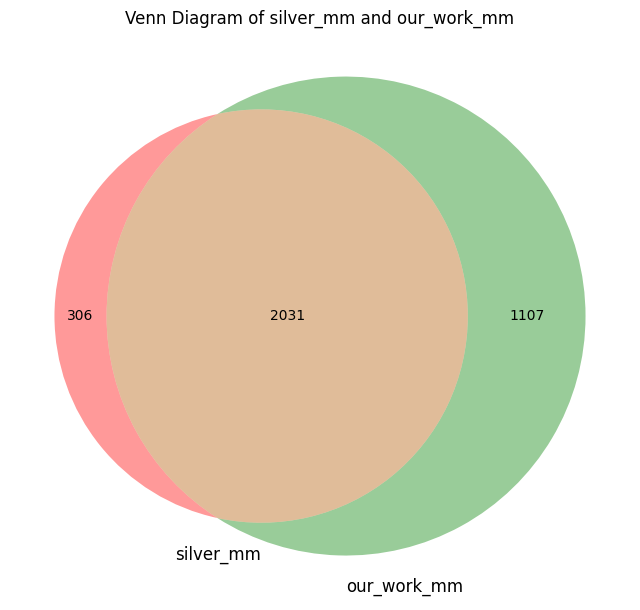

In [38]:
visualize_set_relations(silver_mm, list(set(all_genes)))
